# Experiments
## Bioit set - basic ARTM with regularizers

In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import artm

/tmp/ipykernel_12988/2868503476.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
artm.version()

'0.9.2'

In [ ]:
#Preparing input
input_folder = '../Data/bioit_set/'
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}bioit_set_2_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_2.txt',
    vocab_file_path=f'{input_folder}vocab_2.txt',
    symmetric_cooc_values=True)


In [62]:
#defining regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

new_regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
]
#hyperparameters
num_topics = 5
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#creating the model
model_artm = artm.ARTM(topic_names=topic_names, 
                       class_ids = {"@default_class": 1.0, "@bigram": 1.0},
                       cache_theta=True,
                       scores=scores,
                       regularizers=regularizers,
                        num_topics = num_topics)

#EM hyperparameters
num_collection_passes = 25
#varying regularization coefficients
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -20
# model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

True

In [ ]:
#Fitting the model
model_artm.initialize(dictionary = cooc_dict)
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=num_collection_passes)

In [89]:
def print_measures(model:list):          
    print('Sparsity Phi: {0:.3f} '.format(
        model.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f}'.format(
        model.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_purity))
    
    plt.plot(range(len(model.score_tracker['SparsityPhiScore'].value)),
         model.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Phi Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Phi sparsity')
    plt.show()
    
    plt.plot(range(len(model.score_tracker['SparsityThetaScore'].value)),
             model.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Theta Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Theta sparsity')
    plt.show()
    if type(model) == artm.artm_model.ARTM:
        df = pd.DataFrame.from_dict(model.score_tracker['TopicKernelScore'].contrast).transpose()
        plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel contrast')
        plt.title('Boxplot of Kernel Contrast across topics by Iteration')
        plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
        plt.show()

        df = pd.DataFrame.from_dict(model.score_tracker['TopicKernelScore'].purity).transpose()
        plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel purity')
        plt.title('Boxplot of Kernel Purity across topics by Iteration')
        plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
        plt.show()

        df = pd.DataFrame.from_dict(model.score_tracker['TopKernelScore Coherence'].coherence).transpose()
        plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel coherence')
        plt.title('Boxplot of Kernel Coherence across topics by Iteration')
        plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
        plt.show()
    elif type(model) == artm.hierarchy_utils.ARTM_Level:
        df = pd.DataFrame.from_dict(model._score_tracker['TopicKernelScore'].contrast).transpose()
        plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel contrast')
        plt.title('Boxplot of Kernel Contrast across topics by Iteration')
        plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
        plt.show()

        df = pd.DataFrame.from_dict(model._score_tracker['TopicKernelScore'].purity).transpose()
        plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel purity')
        plt.title('Boxplot of Kernel Purity across topics by Iteration')
        plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
        plt.show()

        df = pd.DataFrame.from_dict(model._score_tracker['TopKernelScore Coherence'].coherence).transpose()
        plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel coherence')
        plt.title('Boxplot of Kernel Coherence across topics by Iteration')
        plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
        plt.show()

In [ ]:
print_measures(model_artm)

In [ ]:
for topic_name in model_artm.topic_names:
    print(
        topic_name + ': ', model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
print(model_artm.phi_)
print(model_artm.get_theta())

## NLP set - basic ARTM with regularizers

In [ ]:
#Preparing input
input_folder = '../Data/nlp_set/'
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_2_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_2.txt',
    vocab_file_path=f'{input_folder}vocab_2.txt',
    symmetric_cooc_values=True)


In [ ]:
#defining regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

new_regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
]
#hyperparameters
num_topics = 5
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#creating the model
model_artm = artm.ARTM(
                       topic_names=topic_names, 
                       class_ids = {"@default_class": 1.0, "@bigram": 1.0},
                       cache_theta=True,
                       scores=scores,
                       regularizers=regularizers,
                        num_topics = num_topics)

#EM hyperparameters
num_collection_passes = 25
#varying regularization coefficients
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -20
# model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [ ]:
#Fitting the model
model_artm.initialize(dictionary = cooc_dict)
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=num_collection_passes)

In [ ]:
print_measures(model_artm)

In [ ]:
for topic_name in model_artm.topic_names:
    print(
        topic_name + ': ', model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

In [ ]:
print(model_artm.phi_)
print(model_artm.get_theta())

# Hierarchical topic models

## Bioit set - hARTM with regularizers

In [73]:
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [74]:
#Define regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

In [75]:
#Define quality scores
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

In [98]:
#Define the model hierarchy
model_artm = artm.hARTM(
    regularizers = regularizers,
    scores=scores,
    cache_theta=True
)

In [99]:
#Add root level
level1 = model_artm.add_level(
    num_topics=5,
    
)

In [100]:
#Initialize
level1.initialize(dictionary = cooc_dict)

In [101]:
#Add first level
level2 = model_artm.add_level(
    num_topics=10
)

In [102]:
#Initialize
level2.initialize(dictionary = cooc_dict)

In [103]:
#Fit
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=25)

In [104]:
print(model_artm.get_level(0).phi_)
print(model_artm.get_level(0).get_theta())

            topic_0   topic_1   topic_2   topic_3   topic_4
afu        0.000176  0.000000  0.000000  0.000000  0.000000
aim        0.000200  0.000205  0.000000  0.000000  0.000000
algorithm  0.002678  0.002191  0.003103  0.000000  0.006489
also       0.001248  0.008887  0.001471  0.001661  0.003873
annot      0.003088  0.008065  0.009003  0.000000  0.000579
...             ...       ...       ...       ...       ...
theta      0.000000  0.000000  0.000000  0.000000  0.000256
traf       0.000000  0.000000  0.000000  0.000000  0.005643
transport  0.000000  0.000000  0.000000  0.000000  0.003738
vehicular  0.000000  0.000000  0.000000  0.000000  0.000256
ﬁcﬂow      0.000000  0.000000  0.000000  0.000000  0.000519

[1995 rows x 5 columns]
               0         1         2         3         4         5         6   \
topic_0  0.985419  0.946272  0.266091  0.025096  0.001626  0.001511  0.018233   
topic_1  0.007712  0.000000  0.449225  0.003949  0.049466  0.000000  0.181630   
topic_2  0.0

Sparsity Phi: 0.835 
Sparsity Theta: 0.449
Kernel contrast: 0.814
Kernel purity: 0.831


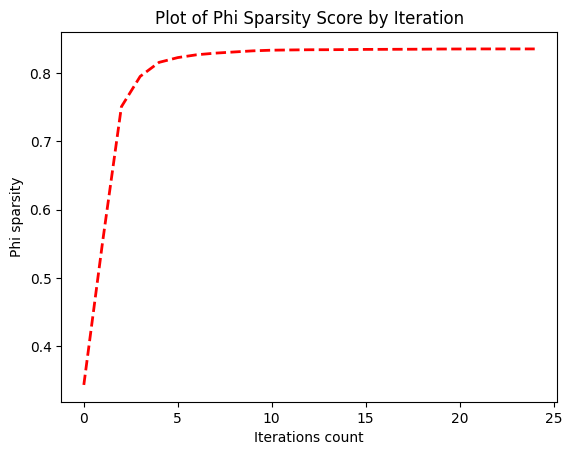

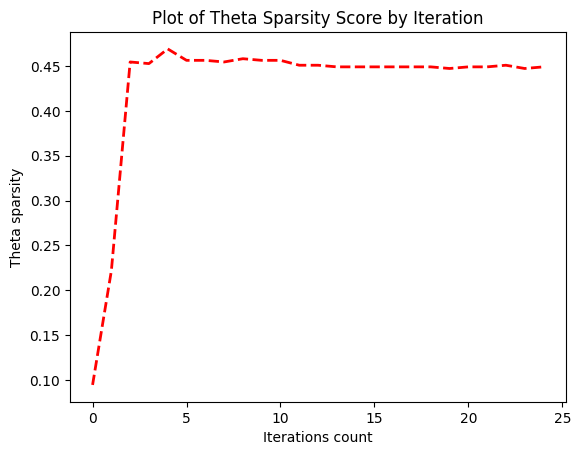

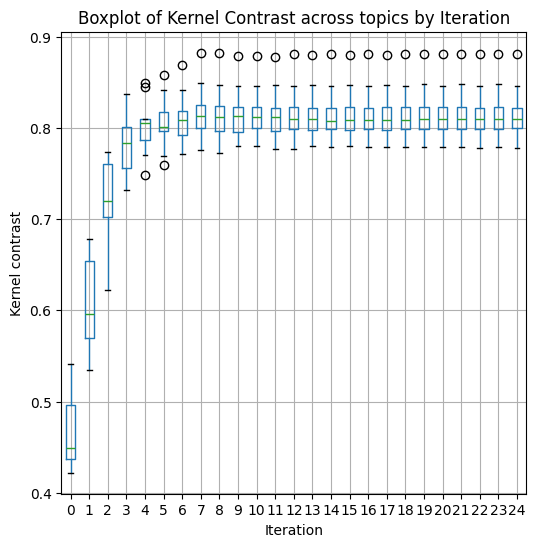

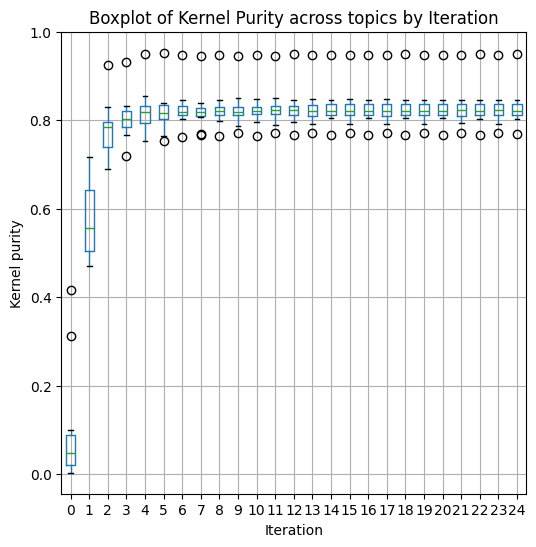

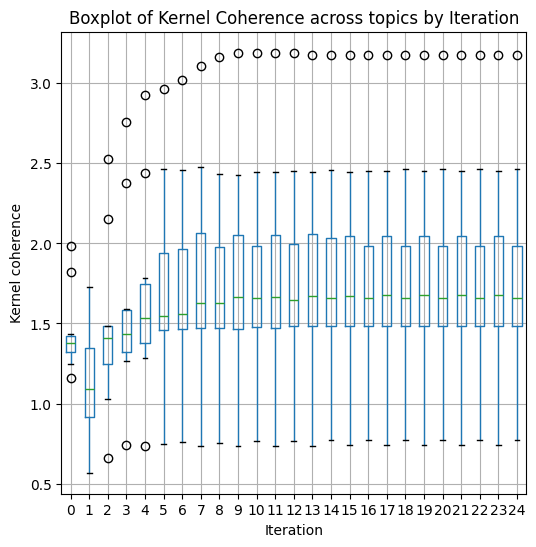

In [92]:
#The way to access score tracker for hARTM models
print_measures(model_artm.get_level(0))

## NLP set - hARTM with regularizers

In [ ]:
#Preparing input
input_folder = '../Data/bioit_set/'
n_gram_value = 2
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}bioit_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

# Note on iterative training process
- This training process will serve as basis to the subsequent development of the hierarchical model
- Coherence calculation requires co-occurence to be calculated prior to modeling
    - revisit preprocessing step
- Regularizers can be added using ```model.regularizers.add```
- Regularizers can not be removed, but can be "turned-off" by setting regularization coefficient value to 0
- The general training procedure is described by Khodorchenko et al., 2020 as follows:

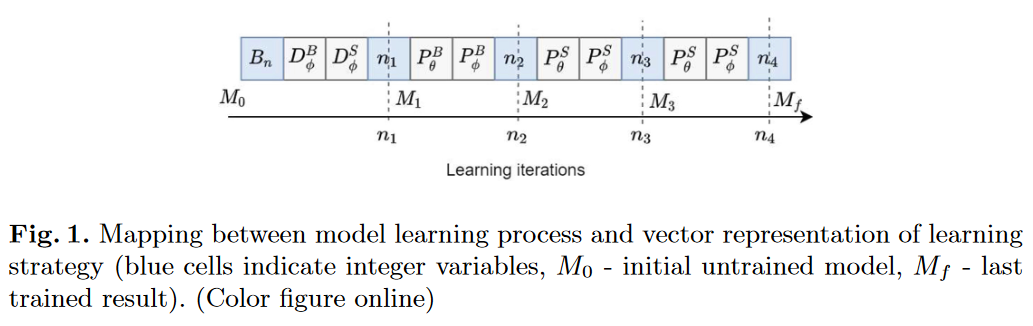

- Suggested hyperparameter search spaces are as follows:

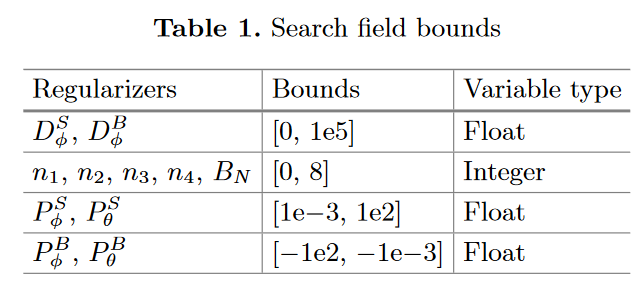

- The differential evolution implementation in Python is possible using the following tool:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html
- Tutorial:
https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/
- Additionally bayesian optimization could be implemented using the following algorithm:
https://github.com/bayesian-optimization/BayesianOptimization